# Library Installations and Drive Dataset Import

In [1]:
!pip install keras-ocr
!pip install transformers[torch]
!pip install --upgrade accelerate -U
!pip show accelerate

Name: accelerate
Version: 0.32.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [2]:
!pip install datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os
import json
import cv2
import numpy as np
import glob
import pandas as pd
import tensorflow as tf

from PIL import Image
from datasets import load_dataset, Dataset

import matplotlib.pyplot as plt
from keras_ocr.pipeline import Pipeline
import keras_ocr.tools as tools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive/


# Sharpen and Denoise Image (Preprocessing) for Keras OCR

0000971160


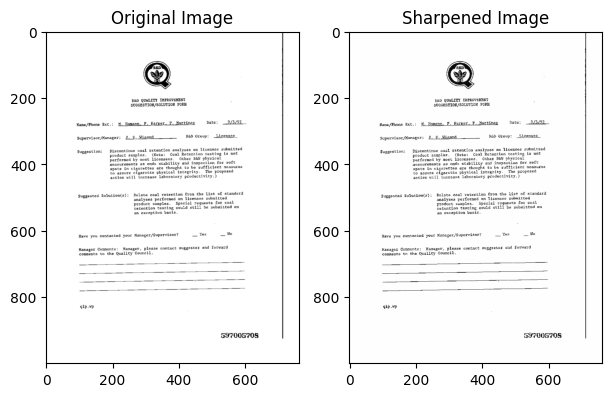

0000989556


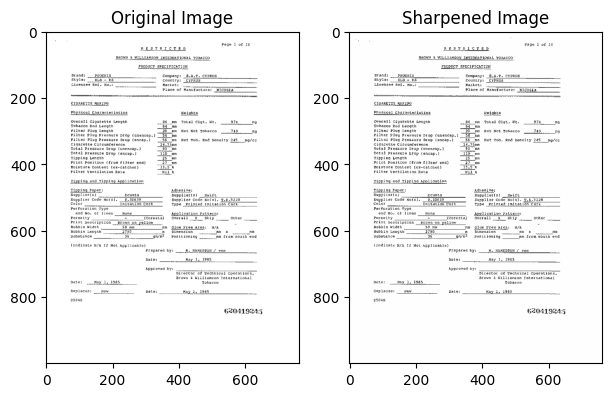

In [4]:
# Define a function to sharpen the image
def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image_sharp

# Define a function to adjust the brightness and contrast
def adjust_brightness_contrast(image, beta, contrast):
    adjusted = cv2.convertScaleAbs(image, alpha=beta, beta=contrast)
    return adjusted

# Define a function to denoise the image
def denoise(image):
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised

# Define a function to process an image
def process_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Sharpen the image
    image_sharp = sharpen(image)

    # Adjust the brightness and contrast
    image_bright = adjust_brightness_contrast(image_sharp, 1.5, 10)

    # Denoise the image
    image_denoised = denoise(image_bright)

    # Show the images side by side
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 4, 2)
    plt.title("Sharpened Image")
    plt.imshow(cv2.cvtColor(image_denoised, cv2.COLOR_BGR2RGB))
    plt.show()

# Get the list of images in the dataset folder
image_folder = "/content/drive/MyDrive/dataset_images/dataset/training_data/images"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")]
image_paths.sort()

# Process each image in the dataset folder
for image_path in image_paths[:2]:
    print(image_path.split("/")[-1].rstrip().split(".")[0])
    process_image(image_path)

# Run Keras OCR

In [15]:
# Define a function to run KerasOCR on an image
def run_keras_ocr(image_path, pipeline, showImages=False):
    # Initialize detected word list
    wordList = []

    # Read the image
    image = cv2.imread(image_path)

    # Run KerasOCR on the image using pipeline object
    detection = pipeline.recognize([image])[0]

    # Extract the text from the OCR results into a list
    for word in detection:
      wordList.extend(word[i] for i in range(len(word)) if isinstance(word[i], str))

    # Plot the image and annotations
    if showImages:
      fig, axs = plt.subplots(1, 2, figsize=(15, 10))

      # Plot original image and tools.drawAnnotations side by side on these subplots
      axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      axs[0].set_title("Original Image")

      # Prevent clutter of annotations
      fig.tight_layout()
      axs[1].axis('off')
      axs[1].set_title("Annotations")
      tools.drawAnnotations(image, detection, ax=axs[1])

    return wordList

if os.path.exists('/content/drive/MyDrive/dataset_images/kerasOCR_results.csv'):
    kerasOCR_resultsDataFrame = pd.read_csv('/content/drive/MyDrive/dataset_images/kerasOCR_results.csv')
    kerasOCR_resultsDataFrame = kerasOCR_resultsDataFrame.rename(columns={'text': 'ocrText'})
    display(kerasOCR_resultsDataFrame)
else:

    # Draw up the pipeline and process each image
    pipeline = Pipeline()

    # Dataframe for image ID vs text in image
    kerasOCR_resultsDataFrame = pd.DataFrame(columns=['image_id', 'text'])

    # Get the list of images in the dataset folder and the text detected in each image
    for image_path in image_paths:
        detectedWordList = run_keras_ocr(image_path, pipeline)
        img_fileName = image_path.split("/")[-1].rstrip().split(".")[0]
        # detectedWordList.sort()
        kerasOCR_resultsDataFrame.loc[len(kerasOCR_resultsDataFrame)] = [img_fileName, " ".join(detectedWordList)]

    display(kerasOCR_resultsDataFrame)
    kerasOCR_resultsDataFrame.to_csv('/content/drive/MyDrive/dataset_images/kerasOCR_results.csv', index=False)

,image_id,ocrText
0,0000971160,red nprovelent quality rad suggestionisclution...
1,0000989556,page l of 10 browe 5 williason international ...
2,0000990274,poilfs fl service request from red by inte rna...
3,0000999294,pdc h c213 827 192iczl project topalines page ...
4,0001118259,recconstituled tobacco icaf substitutions expo...
...,...,...
144,93213298,suavey event racing newport detroit mca divisi...
145,93329540,competitive products new franciscos ca manager...
146,93351929_93351931,registration form coupon code from jessica ara...
147,93380187,faxe exhibit qzgt coupon code registration for...


# Obtain Annotations from dataset

In [17]:
# Load all annotation json files into a single dictionary
def load_annotations(annotationsFolder):
    annotations = {}
    count = 0
    annotationsPath = [os.path.join(annotationsFolder, f) for f in os.listdir(annotationsFolder)]
    annotationsPath.sort()
    for filename in annotationsPath:
        count += 1
        if filename.endswith('.json'):
            with open(filename, "r", encoding='cp1252', errors='ignore') as f:
                fileNameOnly = filename.split("/")[-1].rstrip().split(".")[0]
                annotations[fileNameOnly] = json.loads(f.read())
    print(count)
    return annotations

# Extract the text from the json files
def extract_text(annotations):
    fileAnnotationDict = {}
    for filename in annotations:
        listOfAnnotations = []
        text = ""
        for formComponent in annotations[filename]['form']:
            listOfAnnotations.extend(formComponent['text'].lower().split())
        # listOfAnnotations.sort()
        fileAnnotationDict[filename] = " ".join(listOfAnnotations)
    return fileAnnotationDict

annotationFile = '/content/drive/MyDrive/dataset_images/annotationText.csv'
annotationsFolder = '/content/drive/MyDrive/dataset_images/dataset/training_data/annotations/'
if os.path.exists(annotationFile):
    annotationDataFrame = pd.read_csv(annotationFile)
    annotationDataFrame = annotationDataFrame.rename(columns={'text': 'annotatedText', 'fileName' : 'image_id'})
    display(annotationDataFrame)
else:
    annotationsDict = load_annotations(annotationsFolder)
    fileAnnotationDict = extract_text(annotationsDict)
    annotationDataFrame = pd.DataFrame(columns = ["fileName", "annotatedText"])
    for key in fileAnnotationDict:
        annotationDataFrame.loc[len(annotationDataFrame)] = [key, fileAnnotationDict[key]]
    display(annotationDataFrame)
    annotationDataFrame.to_csv(annotationFile, index=False)

,image_id,annotatedText
0,0000971160,r&d : suggestion: date: licensee yes no 597005...
1,0000989556,brand: style: phoenix company: country: macket...
2,0000990274,date: initiated by: completion country: produc...
3,0000999294,subject: sample: cigarettes: tar 9.1 nic .88 m...
4,0001118259,b&w wcc 621800455 reconstituted tobacco leaf s...
...,...,...
144,93213298,division location mugs invitations: posters co...
145,93329540,date: time: manufacturer: cc: 93329540 new com...
146,93351929_93351931,from: to: cc: media september pack rebecca mag...
147,93380187,"faxed from: to: cc: true 560,000 providence ca..."


# Create Dataset for Attention OCR Model

In [59]:
# Set Device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
sample_fraction = int(0.8 * len(kerasOCR_resultsDataFrame))
combinedDataTrain = pd.merge(kerasOCR_resultsDataFrame, annotationDataFrame, how='inner', on='image_id').iloc[:sample_fraction, :].sample(frac=1).reset_index(drop=True)
combinedDataTest = pd.merge(kerasOCR_resultsDataFrame, annotationDataFrame, how='inner', on='image_id').iloc[sample_fraction:, :].sample(frac=1).reset_index(drop=True)

ocr_results = combinedDataTrain[['image_id', 'ocrText']].rename(columns={'ocrText': 'text'})
annotations = combinedDataTrain[['image_id', 'annotatedText']].rename(columns={'annotatedText': 'text'})

val_ocr_results = combinedDataTest[['image_id', 'ocrText']].rename(columns={'ocrText': 'text'})
val_annotations = combinedDataTest[['image_id', 'annotatedText']].rename(columns={'annotatedText': 'text'})

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class OCRCorrectionDataset(Dataset):
    def __init__(self, ocr_data, annotations, tokenizer, max_len=7):
        self.ocr_data = ocr_data
        self.annotations = annotations
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.ocr_data)

    def __getitem__(self, idx):
        ocr_text = self.ocr_data.iloc[idx]['text']
        correct_text = self.annotations.iloc[idx]['text']

        # Tokenize texts
        ocr_inputs = self.tokenizer(ocr_text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt")
        correct_inputs = self.tokenizer(correct_text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt")

        return {
            'ocr_input_ids': ocr_inputs['input_ids'].squeeze(),
            'ocr_attention_mask': ocr_inputs['attention_mask'].squeeze(),
            'correct_input_ids': correct_inputs['input_ids'].squeeze(),
            'correct_attention_mask': correct_inputs['attention_mask'].squeeze()
        }

# Dataset and DataLoader
dataset = OCRCorrectionDataset(ocr_results, annotations, tokenizer)
val_dataset = OCRCorrectionDataset(val_ocr_results, val_annotations, tokenizer)
dataloader = DataLoader(dataset, batch_size=17, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=30, shuffle=True)

# Set up Attention Model for Text Correction

In [60]:
class AttentionOCRCorrectionModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super(AttentionOCRCorrectionModel, self).__init__()
        self.encoder = BertModel.from_pretrained('bert-base-uncased')
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, input_ids, attention_mask, target_ids):
        # Get encoder outputs
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Decoder input is the target sequence shifted by one
        decoder_inputs = target_ids[:, :-1]

        # Embed decoder inputs
        decoder_inputs = self.embedding(decoder_inputs)

        # Pass through LSTM decoder
        decoder_outputs, _ = self.decoder(decoder_inputs)

        # Apply attention mechanism
        attention_outputs, _ = self.attention(decoder_outputs, encoder_outputs, encoder_outputs)

        # Final linear layer to get logits
        outputs = self.fc(attention_outputs)

        return outputs

# Hyperparameters
hidden_dim = 768
vocab_size = len(tokenizer.vocab)

# Initialize model
model = AttentionOCRCorrectionModel(hidden_dim, vocab_size).to(device)

# Print model summary
print(model)

AttentionOCRCorrectionModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# Training

In [62]:
# Define a validation function
def validate(model, val_dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['ocr_input_ids'].to(device).long()
            attention_mask = batch['ocr_attention_mask'].to(device).long()
            target_ids = batch['correct_input_ids'].to(device).long()

            # Forward pass
            outputs = model(input_ids, attention_mask, target_ids)

            # Calculate loss
            outputs = outputs.view(-1, vocab_size)
            targets = target_ids[:, 1:].contiguous().view(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_dataloader)

# Training parameters
num_epochs = 150
batch_size = 17
learning_rate = 5e-2
max_increasing_epochs = 9  # Number of epochs with increasing validation loss before taking action
best_val_loss = float('inf')
best_model_weights = None
increasing_epochs = 0

# Initialize model
model = AttentionOCRCorrectionModel(hidden_dim, vocab_size).to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        input_ids = batch['ocr_input_ids'].to(device).long()
        attention_mask = batch['ocr_attention_mask'].to(device).long()
        target_ids = batch['correct_input_ids'].to(device).long()

        # Forward pass
        outputs = model(input_ids, attention_mask, target_ids)

        # Calculate loss
        outputs = outputs.view(-1, vocab_size)
        targets = target_ids[:, 1:].contiguous().view(-1)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = total_loss / len(dataloader)

    # Validate the model
    val_loss = validate(model, val_dataloader, criterion)

    # Print training and validation statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check if validation loss is increasing
    if val_loss > best_val_loss:
        increasing_epochs += 1
        if increasing_epochs > max_increasing_epochs:
            # Reduce learning rate and load best weights
            print(f'Validation loss has been increasing for {increasing_epochs} epochs. Taking action...')
            # Example action: Reduce learning rate
            for param_group in optimizer.param_groups:
                if param_group['lr'] > 5e-4:
                  param_group['lr'] *= 0.1  # Reduce learning rate by a factor
                  print(f'Learning rate reduced to: {param_group["lr"]}')

            # Load best model weights
            if best_model_weights is not None:
                model.load_state_dict(best_model_weights)
                print("Best model weights loaded.")

            # Reset increasing_epochs counter
            increasing_epochs = 0
    else:
        # Reset increasing_epochs counter if val_loss decreases
        increasing_epochs = 0
        best_val_loss = val_loss
        best_model_weights = model.state_dict()

# After training completes, load the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), '/content/drive/MyDrive/dataset_images/bestAttention.pth')
    print("Best model weights saved.")

print("Training complete.")

Epoch [1/150], Train Loss: 9697.9253, Val Loss: 3917.0938
Epoch [2/150], Train Loss: 13132.8931, Val Loss: 19423.3809
Epoch [3/150], Train Loss: 10229.5106, Val Loss: 9853.2705
Epoch [4/150], Train Loss: 4735.6389, Val Loss: 1970.4939
Epoch [5/150], Train Loss: 2509.0948, Val Loss: 2314.0171
Epoch [6/150], Train Loss: 1799.4224, Val Loss: 1384.1829
Epoch [7/150], Train Loss: 2479.8618, Val Loss: 2363.7668
Epoch [8/150], Train Loss: 2457.0572, Val Loss: 1480.8824
Epoch [9/150], Train Loss: 903.6822, Val Loss: 1234.3186
Epoch [10/150], Train Loss: 670.4307, Val Loss: 420.6829
Epoch [11/150], Train Loss: 464.6821, Val Loss: 768.2868
Epoch [12/150], Train Loss: 322.4122, Val Loss: 354.1960
Epoch [13/150], Train Loss: 210.0932, Val Loss: 197.2213
Epoch [14/150], Train Loss: 151.7022, Val Loss: 186.5038
Epoch [15/150], Train Loss: 113.7568, Val Loss: 135.8870
Epoch [16/150], Train Loss: 95.7192, Val Loss: 166.7985
Epoch [17/150], Train Loss: 86.1037, Val Loss: 173.0511
Epoch [18/150], Train 

# Inference

In [63]:
def run_keras_ocr(image_path, pipeline, showImages=False):
    # Initialize detected word list
    wordList = []

    # Read the image
    image = cv2.imread(image_path)

    # Run KerasOCR on the image using pipeline object
    detection = pipeline.recognize([image])[0]

    # Extract the text from the OCR results into a list
    for word in detection:
        wordList.append(word[0])

    # Plot the image and annotations
    if showImages:
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))

        # Plot original image and tools.drawAnnotations side by side on these subplots
        axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original Image")

        # Prevent clutter of annotations
        fig.tight_layout()
        axs[1].axis('off')
        axs[1].set_title("Annotations")
        keras_ocr.tools.drawAnnotations(image, detection, ax=axs[1])

    return wordList

if os.path.exists('/content/drive/MyDrive/dataset_images/bertAttention.pth'):
  # Load the trained model
  model_path = '/content/drive/MyDrive/dataset_images/bertAttention.pth'
  model = AttentionOCRCorrectionModel(hidden_dim, vocab_size)
  model.load_state_dict(torch.load(model_path))
  model.to(device)

# Load the tokenizer and set Bert in evaluation mode
model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text, tokenizer):
    encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    return input_ids, attention_mask

def prepare_target_text(target_text, tokenizer):
    target_encoding = tokenizer(target_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    target_ids = target_encoding['input_ids'].to(device)
    return target_ids

def correct_text(detected_text, model, tokenizer):
    input_ids, attention_mask = preprocess_text(detected_text, tokenizer)

    with torch.no_grad():
        target_ids = input_ids.clone()  # Dummy target ids for inference
        outputs = model(input_ids, attention_mask, target_ids)

        # Get the most likely token ids
        predicted_ids = outputs.argmax(dim=-1)

        # Decode the token ids to text
        corrected_text = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)

    return corrected_text

In [64]:
image_path = '/content/drive/MyDrive/dataset_images/dataset/testing_data/images/82092117.png'

# Run KerasOCR on the image
pipeline = Pipeline()
detected_text_list = run_keras_ocr(image_path, pipeline)

# Combine the detected text into a single string
detected_text = ' '.join(detected_text_list)

# Step 2: Correct the detected text using the trained model
corrected_text = correct_text(detected_text, model, tokenizer)

print("Detected Text: ", detected_text, len(detected_text.split()))
print("Corrected Text: ", corrected_text, len(corrected_text.split()))

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 794ms/step


7/7 [==============================] - 3s 67ms/step
Detected Text:  s0e7 9e 17146 pe ci gen admin office faxisiaabe dec 10 at attorney general betty ds montgomery confidential facsimile transmission cover sheet faxno 1614 466s087 tob georg barcody faxnumbers sso 3572 phone numbers 870s37776 date 1210s pages including number of cover sheet flunn senderphone numbers june for eric bronmela aeg s994 special instructions you do not receive any of the pages properly de please contactsender possible as soon as note this message is intended only for the of ndvidual use thie or entity to whom t s addressed and may contain information that ls privileged confidentlall and exempt from disclosure applicable under law lf the reader of bis is the intenced ecpicnt he responsible fot celivering messagg not ot eunployse agent or the intenced reciplens bereby notifed disseminations disniburion to he ihat message you ag any of uhis communication copying conveying n ls surictly droliblted l ot ay naner you